## KNN: Can essays be clustered by score categories using a KNN model?

## Approach
We use TF-IDF vectors here, as previous analyses have shown that the band score is related to vocabulary diversity.
For visualization, PCA and UMAP are used, among other methods.

## Key findings
The band score is predicted more effectively using k-NN compared to k-means, achieving an accuracy of approximately 63%.
A key factor in improving performance was the use of oversampling to address class imbalance.
However, the relatively low number of neighbors suggests that the score classes are widely distributed, which may impact the model's generalization ability.

## Imports und Setup
---

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.neighbors import KNeighborsClassifier

## Data Import
---

In [2]:
df_train = pd.read_csv("../data/clean_train.csv")
df_test = pd.read_csv("../data/clean_test.csv")

In [3]:
df_train.shape

(9048, 14)

In [4]:
prompts_train = df_train["prompt"]
essays_train = df_train["essay"]

y_train_pd = df_train["band_score"]

prompts_test = df_test["prompt"]
essays_test = df_test["essay"]

y_test_pd = df_test["band_score"]

## Basic statistics

---

Display the band_score distribution

(9048,)


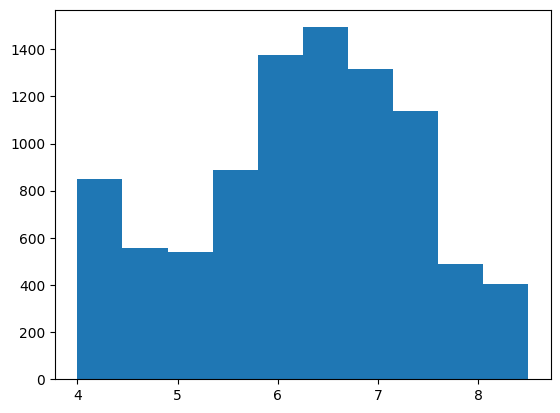

In [5]:
plt.hist(y_train_pd)
print(y_train_pd.shape)

## The essays are vectorized using both a TF-IDF vectorizer

---

In [6]:
prompt_vec = TfidfVectorizer(
    tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
)

essay_vec = TfidfVectorizer(
    tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
)

In [7]:
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

embeddings_prompt_train = prompt_vec.fit_transform(prompts_train)
print(embeddings_prompt_train.shape)
embeddings_essay_train = essay_vec.fit_transform(essays_train)
print(embeddings_essay_train.shape)

embeddings_prompt_test = prompt_vec.transform(prompts_test)
print(embeddings_prompt_test.shape)
embeddings_essay_test = essay_vec.transform(essays_test)
print(embeddings_essay_test.shape)

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(9048, 16596)
(9048, 597414)
(454, 16596)
(454, 597414)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_essay_train, y_train_pd, random_state=42
)

For classification, the scores need to be converted into integers.

In [9]:
y_train = y_train * 10
y_test = y_test * 10

## First try on raw data

---

In [10]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [11]:
result = model.predict(X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.36      0.02      0.05       207
        45.0       0.09      0.01      0.01       146
        50.0       0.25      0.01      0.02       124
        55.0       0.11      0.06      0.08       188
        60.0       0.15      0.29      0.20       355
        65.0       0.16      0.31      0.21       378
        70.0       0.16      0.21      0.18       338
        75.0       0.12      0.10      0.11       299
        80.0       0.09      0.01      0.01       129
        85.0       0.00      0.00      0.00        98

    accuracy                           0.15      2262
   macro avg       0.15      0.10      0.09      2262
weighted avg       0.16      0.15      0.12      2262

[[  5   2   0   8  72  62  36  20   2   0]
 [  1   1   0   2  52  44  34  11   1   0]
 [  0   0   1   7  38  38  26  12   2   0]
 [  1   1   0  11  58  64  31  19   1   2]
 [  4   5   1  22 104 122  58  38   1   0]
 [  1   0   1  20 111 118 

In [12]:
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results["test_score"])
avg_score = np.average(cv_results["test_score"])

print("avg_score=%.2f%% " % (avg_score * 100,))

[0.13549337 0.14138439 0.17820324 0.14727541 0.15316642 0.17525773
 0.1519174  0.16814159 0.16371681 0.15339233]
avg_score=15.68% 


## Combine the prompt and the essay

---

In [13]:
pE_train = pd.concat([prompts_train, essays_train], axis=1)
pE_train["komb"] = pE_train["prompt"] + pE_train["essay"]
pE_test = pd.concat([prompts_test, essays_test], axis=1)
pE_test["komb"] = pE_test["prompt"] + pE_test["essay"]

embeddings_promptE_train = prompt_vec.fit_transform(pE_train["komb"])
print(embeddings_promptE_train.shape)


embeddings_promptE_test = prompt_vec.transform(pE_test["komb"])
print(embeddings_promptE_test.shape)

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(9048, 606674)
(454, 606674)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_promptE_train, y_train_pd, random_state=42
)

In [15]:
y_train = y_train * 10
y_test = y_test * 10

In [16]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [17]:
result = model.predict(X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.09      0.03      0.04       207
        45.0       0.25      0.01      0.03       146
        50.0       0.00      0.00      0.00       124
        55.0       0.08      0.06      0.07       188
        60.0       0.16      0.31      0.21       355
        65.0       0.17      0.36      0.23       378
        70.0       0.16      0.17      0.17       338
        75.0       0.14      0.09      0.11       299
        80.0       0.11      0.01      0.01       129
        85.0       0.50      0.01      0.02        98

    accuracy                           0.16      2262
   macro avg       0.17      0.11      0.09      2262
weighted avg       0.16      0.16      0.12      2262

[[  6   0   0  17  77  68  29  10   0   0]
 [  4   2   0  11  47  45  25  12   0   0]
 [  5   0   0  16  39  34  17  10   2   1]
 [  9   2   0  12  52  64  34  14   1   0]
 [ 12   2   1  21 110 129  51  29   0   0]
 [ 10   0   0  27 118 135 

In [18]:
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results["test_score"])
avg_score = np.average(cv_results["test_score"])

print("avg_score=%.2f%% " % (avg_score * 100,))

[0.16053019 0.1443299  0.16494845 0.14285714 0.16053019 0.16789396
 0.14749263 0.16224189 0.15929204 0.1460177 ]
avg_score=15.56% 


## Interim result

---

On the raw data, classification using TF-IDF does not appear to be feasible.

### PCA


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca.fit(embeddings_promptE_train)

PCA(n_components=64)

In [20]:
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)

In [21]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(pca_X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [22]:
result = model.predict(pca_X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.22      0.13      0.16       207
        45.0       0.09      0.01      0.01       146
        50.0       0.17      0.02      0.03       124
        55.0       0.10      0.06      0.08       188
        60.0       0.17      0.27      0.21       355
        65.0       0.17      0.31      0.22       378
        70.0       0.15      0.19      0.17       338
        75.0       0.16      0.16      0.16       299
        80.0       0.17      0.01      0.01       129
        85.0       0.00      0.00      0.00        98

    accuracy                           0.16      2262
   macro avg       0.14      0.12      0.11      2262
weighted avg       0.15      0.16      0.14      2262

[[ 27   1   1  15  64  47  28  23   1   0]
 [ 15   1   0  12  30  41  29  18   0   0]
 [  8   1   2   6  32  45  19  11   0   0]
 [  7   1   0  12  53  52  46  17   0   0]
 [ 24   1   2  23  95 104  66  37   2   1]
 [ 16   1   2  18  97 117 

In [23]:
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results["test_score"])
avg_score = np.average(cv_results["test_score"])

print("avg_score=%.2f%% " % (avg_score * 100,))

[0.16053019 0.1443299  0.16494845 0.14285714 0.16053019 0.16789396
 0.14749263 0.16224189 0.15929204 0.1460177 ]
avg_score=15.56% 


PCA does not seem to improve the result.

### Umap


Uniform Manifold Approximation and Projection for Dimension Reduction

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import umap

2025-06-21 21:45:53.162122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 21:45:53.170472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750535153.179015   12086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750535153.181537   12086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750535153.188200   12086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [25]:
umap = umap.UMAP()
umap.fit(embeddings_promptE_train)

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [26]:
umap_X_train = umap.transform(X_train)

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [27]:
umap_X_test = umap.transform(X_test)

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [28]:
umap_X_train.shape

(6786, 2)

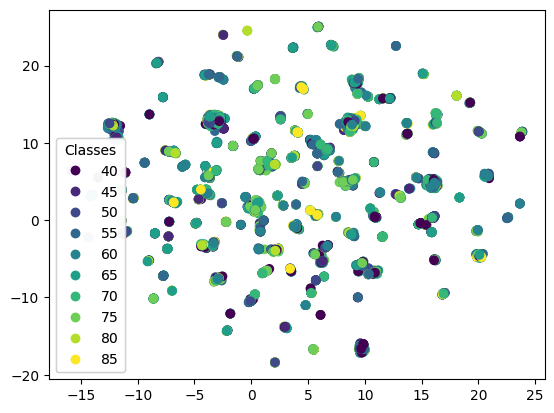

In [29]:
fig, ax = plt.subplots()
scatter = ax.scatter(umap_X_train[:, 0], umap_X_train[:, 1], c=y_train)


# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()

In [30]:
model = KNeighborsClassifier(n_neighbors=25)
model.fit(umap_X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [31]:
result = model.predict(umap_X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.12      0.12      0.12       207
        45.0       0.09      0.03      0.04       146
        50.0       0.18      0.08      0.11       124
        55.0       0.11      0.12      0.12       188
        60.0       0.15      0.23      0.18       355
        65.0       0.16      0.26      0.20       378
        70.0       0.14      0.14      0.14       338
        75.0       0.15      0.12      0.13       299
        80.0       0.14      0.02      0.04       129
        85.0       0.08      0.01      0.02        98

    accuracy                           0.15      2262
   macro avg       0.13      0.11      0.11      2262
weighted avg       0.14      0.15      0.13      2262

[[25  2  1 22 47 56 36 18  0  0]
 [16  4  0 18 38 33 20 17  0  0]
 [16  2 10 15 29 23 17 10  1  1]
 [20  3  1 22 40 49 35 16  0  2]
 [31  6 10 36 81 98 52 37  3  1]
 [32  7  9 32 89 99 68 40  1  1]
 [24 11  8 17 81 97 48 43  4  5]
 [23  8 10

UMAP also does not appear to be very helpful.

### Oversampling

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
y_train_pd_class = y_train_pd * 10
X_resampled, y_resampled = SMOTE().fit_resample(
    embeddings_promptE_train, y_train_pd_class
)

In [34]:
print(X_resampled.shape)
print(y_resampled.shape)

(14930, 606674)
(14930,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, random_state=42
)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [36]:
result = model.predict(X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.46      0.80      0.59       361
        45.0       0.52      0.93      0.67       377
        50.0       0.49      0.86      0.63       371
        55.0       0.55      0.61      0.58       369
        60.0       0.44      0.08      0.14       386
        65.0       0.44      0.03      0.05       376
        70.0       0.58      0.16      0.25       354
        75.0       0.65      0.31      0.42       386
        80.0       0.68      0.88      0.77       376
        85.0       0.69      0.95      0.80       377

    accuracy                           0.56      3733
   macro avg       0.55      0.56      0.49      3733
weighted avg       0.55      0.56      0.49      3733

[[289  22  20  10   0   2   3   1   6   8]
 [  6 350   8   4   1   0   0   3   4   1]
 [ 12  21 318  10   3   0   0   0   2   5]
 [ 40  34  28 226   8   2   4   7  13   7]
 [ 81  67  82  44  32   2   5  15  27  31]
 [ 83  65  79  40   8  11 

In [37]:
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results["test_score"])
avg_score = np.average(cv_results["test_score"])

print("avg_score=%.2f%% " % (avg_score * 100,))

[0.53571429 0.53482143 0.54732143 0.53125    0.55178571 0.52410714
 0.54107143 0.53708668 0.54423592 0.53351206]
avg_score=53.81% 


Oversampling with SMOTE significantly improves the accuracy to approximately 54%.

### PCA + oversampling

In [38]:
from sklearn.decomposition import PCA

pca_over = PCA(n_components=512)
pca_over.fit(X_resampled)

PCA(n_components=512)

In [39]:
pca_X_train = pca_over.transform(X_train)
pca_X_test = pca_over.transform(X_test)

In [40]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(pca_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [41]:
result = model.predict(pca_X_test)
eva_mat = sklearn.metrics.classification_report(y_test, result)
print(eva_mat)
confMat = sklearn.metrics.confusion_matrix(y_test, result)
print(confMat)

              precision    recall  f1-score   support

        40.0       0.75      0.77      0.76       361
        45.0       0.85      0.91      0.88       377
        50.0       0.81      0.83      0.82       371
        55.0       0.64      0.69      0.67       369
        60.0       0.38      0.32      0.35       386
        65.0       0.33      0.25      0.28       376
        70.0       0.37      0.43      0.40       354
        75.0       0.52      0.54      0.53       386
        80.0       0.87      0.86      0.86       376
        85.0       0.90      0.92      0.91       377

    accuracy                           0.65      3733
   macro avg       0.64      0.65      0.65      3733
weighted avg       0.64      0.65      0.64      3733

[[278   6   3   4  21  22  11  12   2   2]
 [  4 344   5   3   6   4   5   3   2   1]
 [  3   3 309  13  16  10   7   7   1   2]
 [  7   7  11 255  28  21  19  17   3   1]
 [ 31  17  21  41 122  44  61  39   3   7]
 [ 20   9  17  32  47  93 

In [42]:
cv_results = cross_validate(model, pca_X_train, y_train, cv=10)
print(cv_results["test_score"])
avg_score = np.average(cv_results["test_score"])

print("avg_score=%.2f%% " % (avg_score * 100,))

[0.62410714 0.62321429 0.63571429 0.62410714 0.62678571 0.62142857
 0.64553571 0.6461126  0.63360143 0.63538874]
avg_score=63.16% 


PCA combined with oversampling appears to be the most effective approach here, although PCA requires a high number of components, and the number of neighbors must be reduced to 1.

### [`Click here to go back to the Homepage`](../Homepage.md)